In [ ]:
# Assignment set 1 challenge 1

In [ ]:
# Import data
import gwpy
from gwpy.timeseries import TimeSeries

# 1. Load the data into memory. What are the sampling rate and duration of the data?
filename = "challenge1.gwf"
channel = "H1:CHALLENGE1"
data = TimeSeries.read(filename, channel)
sampling_rate = data.sample_rate.value
duration = data.duration.value
print(f"Sampling Rate: {sampling_rate}")
print(f"Duration: {duration}")

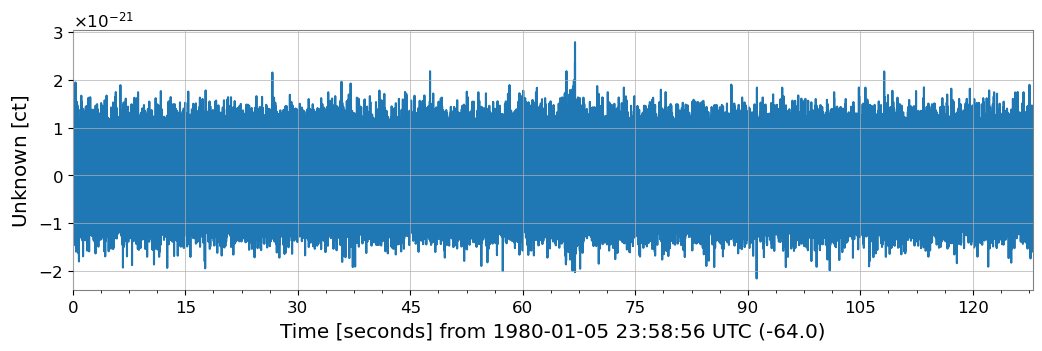

In [6]:
# Data in the time domain
plot = data.plot()

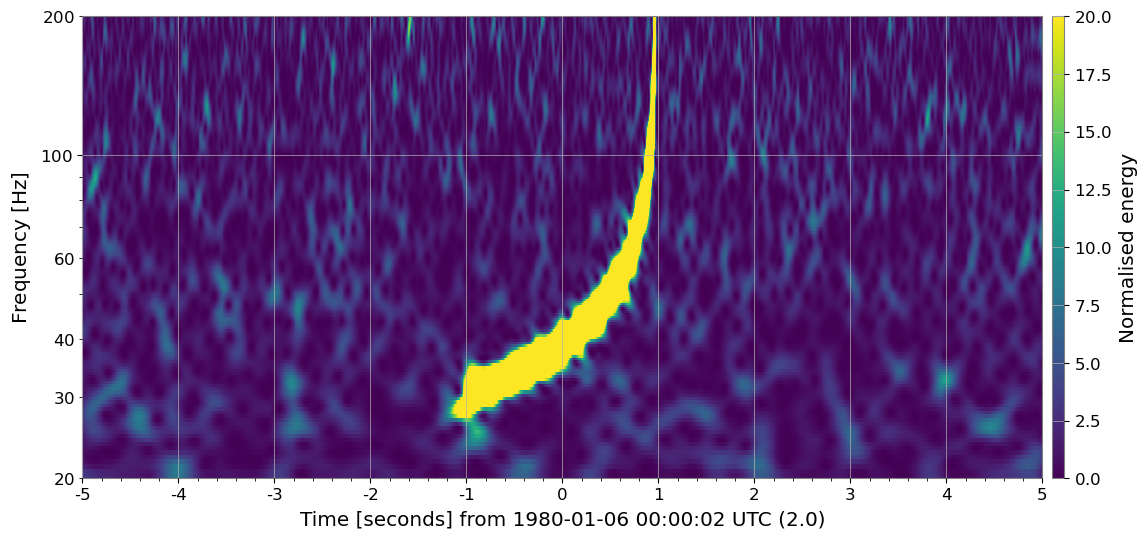

In [51]:
# Spectogram of the data
gps1 = 2
qdata = data.q_transform(frange=(20, 200), qrange=(20, 30), outseg=(gps1-5,gps1+5))
plot = qdata.plot()
ax = plot.gca()
ax.set_epoch(gps1)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
plot.colorbars[0].mappable.set_clim(0,20)
plot.refresh()
# We can see that the merger occurs at approximately t=3s

In [ ]:
# Assignment set 1 challenge 2

In [41]:
# 1. Load the data into memory
filename = "challenge2.gwf"
channel = "H1:CHALLENGE2"
data1 = TimeSeries.read(filename, channel)

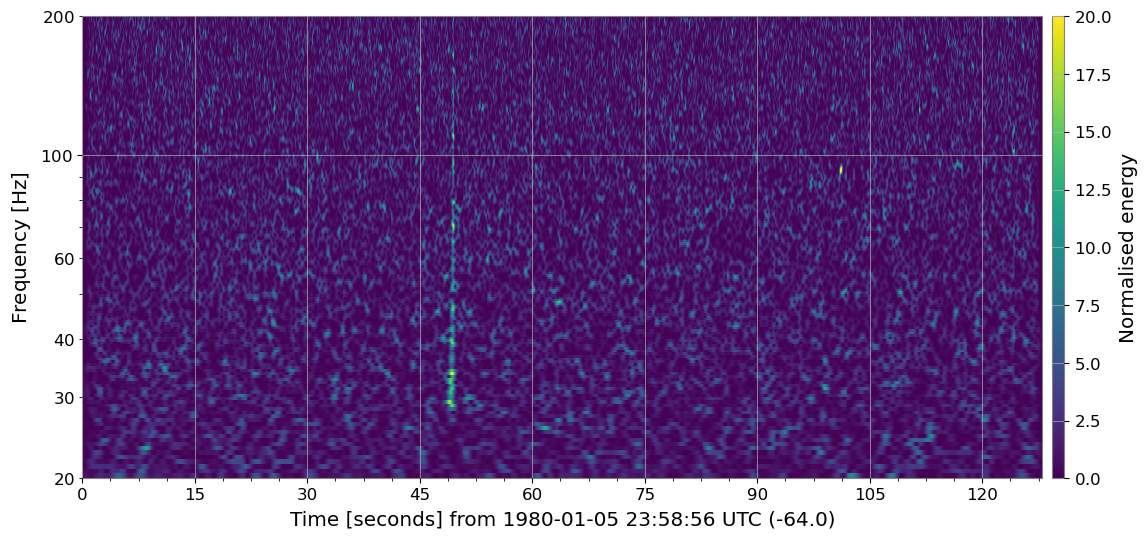

In [43]:
qdata1 = data1.q_transform(frange=(20, 200), qrange=(100, 110))
plot = qdata1.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
plot.colorbars[0].mappable.set_clim(0,20)
plot.refresh()

In [45]:
from pycbc.waveform import get_td_waveform
import pylab

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


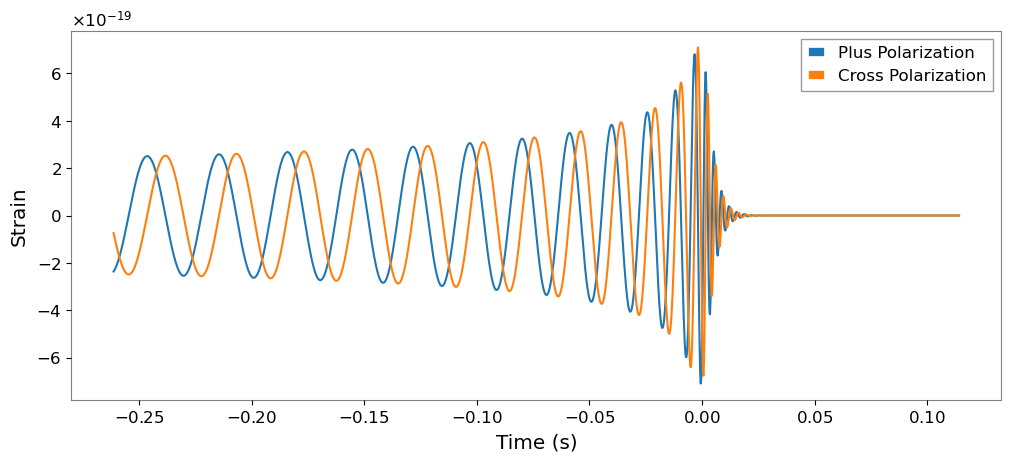

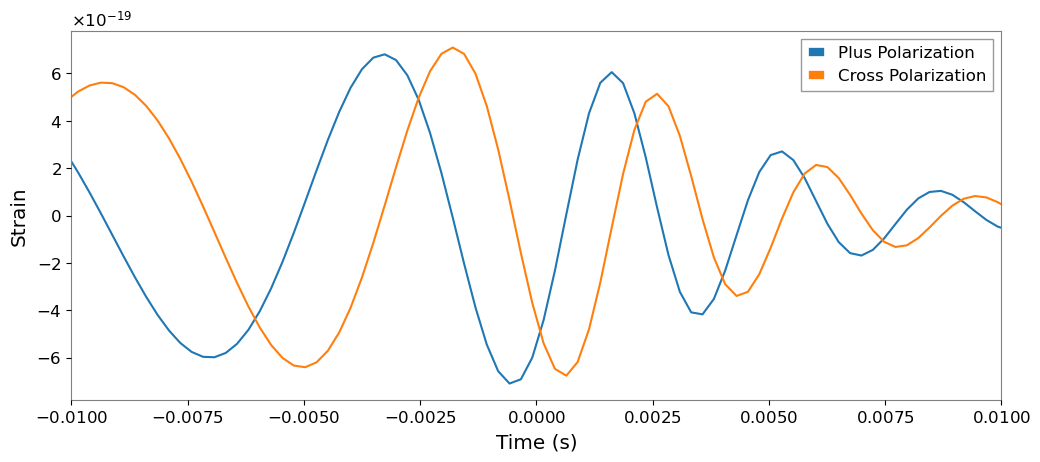

In [46]:
# Get sampling rate
sr1 = data1.sample_rate.value
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sr1,
                         f_lower=30)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

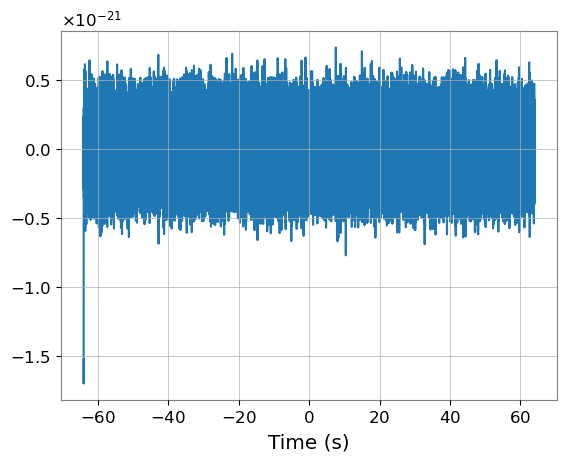

In [65]:
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

from pycbc import frame
strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/sr1)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

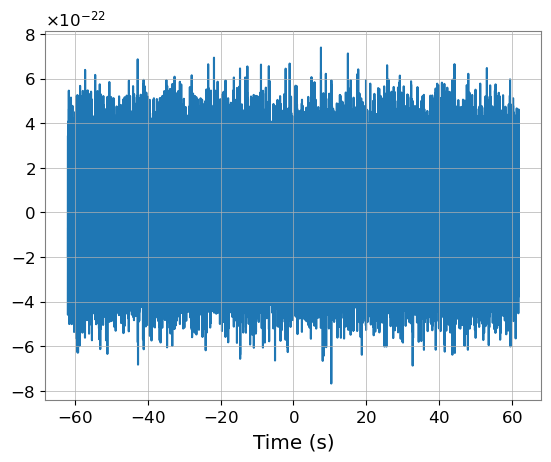

In [66]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [67]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = conditioned.psd(4)

psd = interpolate(psd, conditioned.delta_f)

psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [68]:
from pycbc.waveform import get_td_waveform

m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

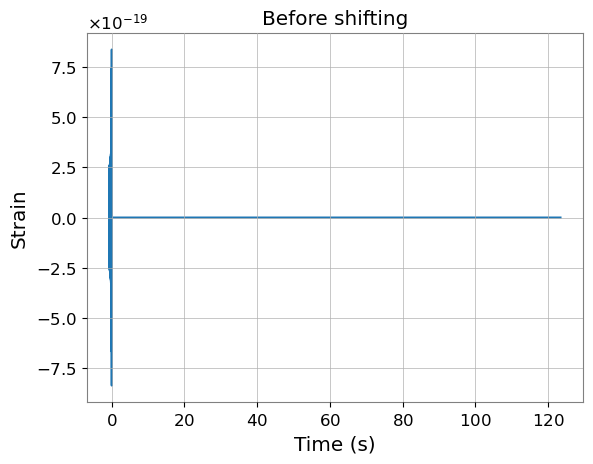

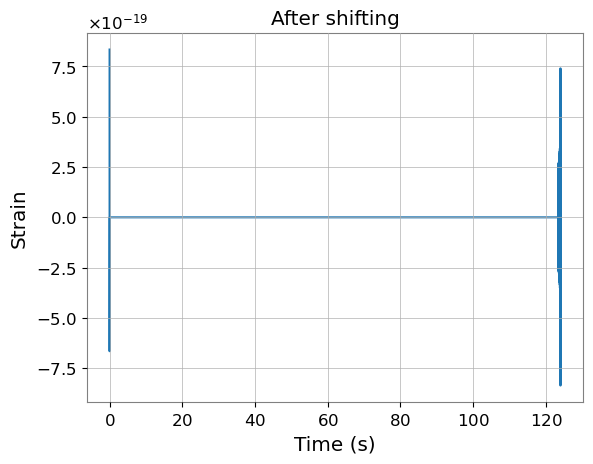

In [73]:
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

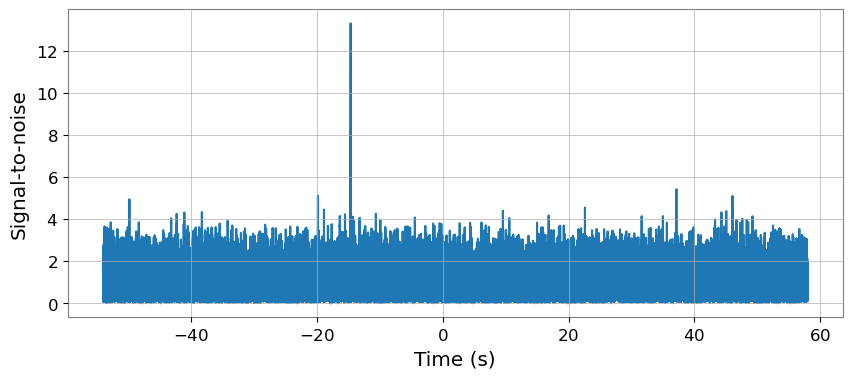

We found a signal at -14.6357421875s with SNR 13.293290312798275


In [71]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,abs(snrp)))

In [ ]:
# Assignment set 2 challenge 2

Text(0, 0.5, 'strain')

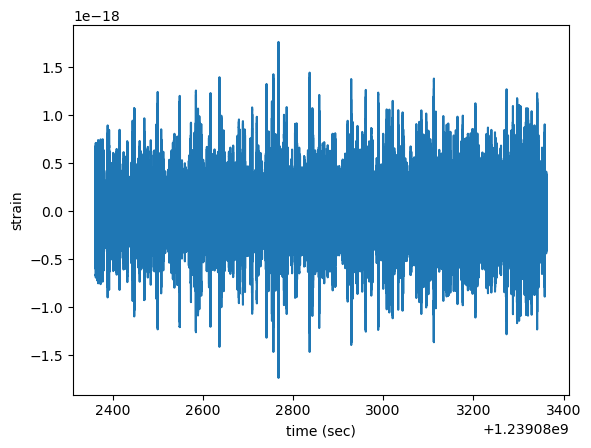

In [4]:
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt
d = np.load('noise_ts_4096Hz.npy')
time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-time[0])
data = d
#frequency domain version of the data
fd = data.to_frequencyseries()
plt.plot(time, data)
plt.xlabel('time (sec)')
plt.ylabel('strain')

(1e-47, 1e-42)

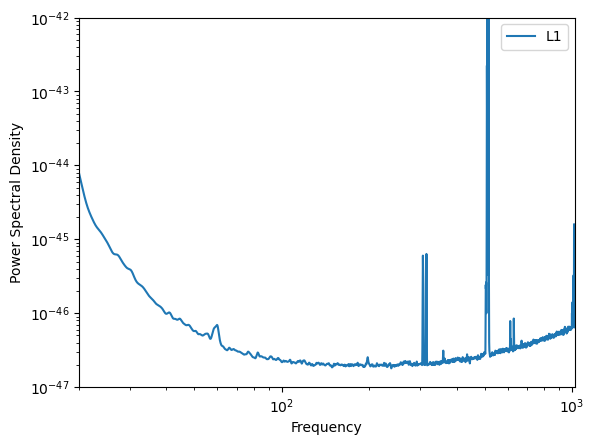

In [5]:
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
import pylab
psd1={}
psd1 = interpolate(data.psd(2),fd.delta_f)

psd1=inverse_spectrum_truncation(psd1,int(2*data.sample_rate),low_frequency_cutoff=15.0,trunc_method='hann')
pylab.loglog(psd1.sample_frequencies,psd1,label='L1')
pylab.xlabel("Frequency")
pylab.ylabel("Power Spectral Density")
pylab.legend()

pylab.xlim(20,1024)
pylab.ylim(1e-47,1e-42)

In [16]:
from pycbc.waveform import get_td_waveform

m = 10 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=data.delta_t,
                     f_lower=20)

hp.resize(len(data))

Text(0, 0.5, 'Strain')

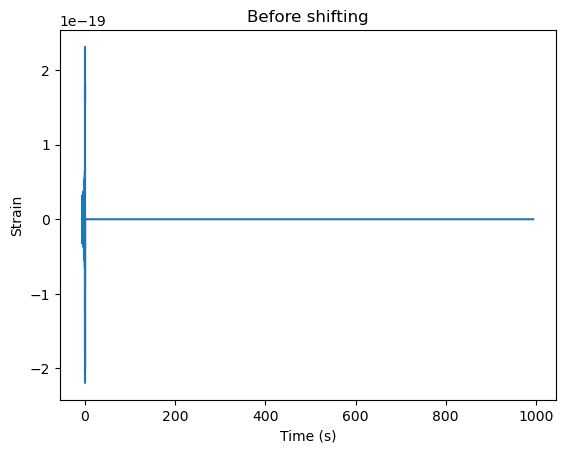

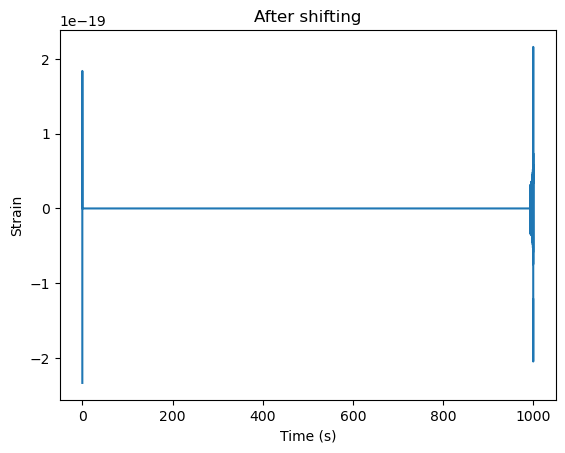

In [17]:
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

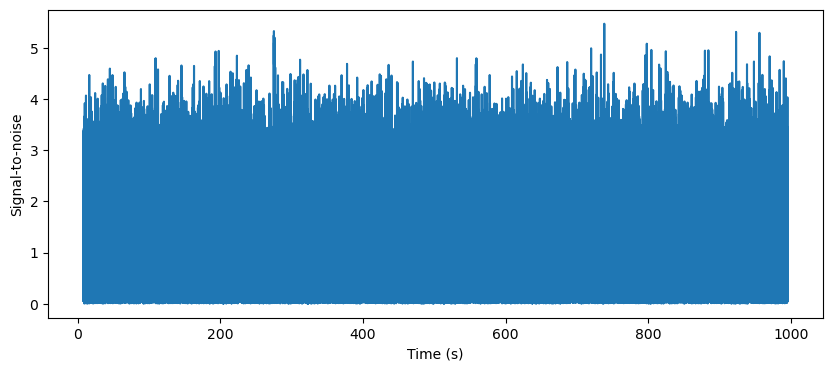

We found a signal at 738.480224609375s with SNR 5.46913006973464


In [18]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, data,
                     psd=psd1, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,abs(snrp)))

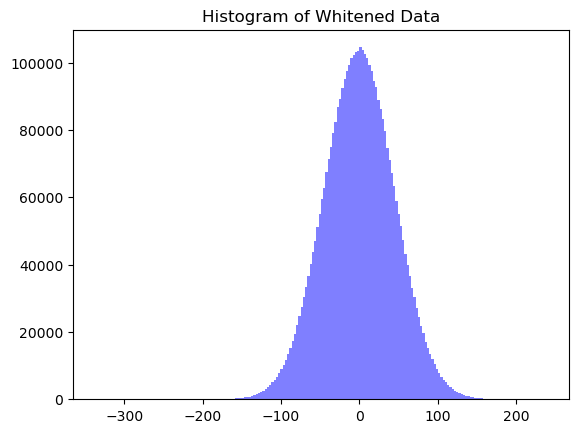

In [20]:
import pycbc.psd
white_data = (data.to_frequencyseries() / psd1**0.5).to_timeseries()
white_data=white_data.crop(5,5)
#lot histogram of whitened data
unga = 200
n, bins, patches = plt.hist(white_data, unga, facecolor='blue', alpha=0.5)
plt.title("Histogram of Whitened Data")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

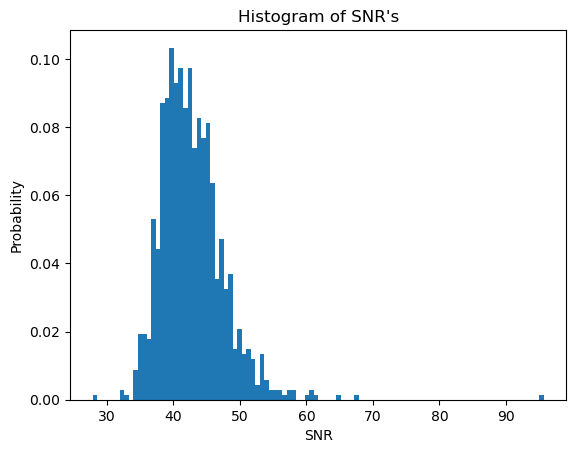

In [24]:
# Generate Waveform
from pycbc.waveform import get_fd_waveform
f_final = 2048.0

# Generate frequency domain waveform
hp, hc = get_fd_waveform(approximant="TaylorF2", 
                          mass1=10, 
                          mass2=10, 
                          delta_f=1.0/200.0, 
                          distance=500,  
                          f_lower=20, 
                          f_final=2048)

# Calculate PSD
psds = pycbc.psd.interpolate(pycbc.psd.welch(data), hp.delta_f)

# Calculate SNR
snr = np.sqrt(pycbc.filter.sigmasq(hp, psds))

# Parameters for data slicing
slices = 1000
data_slice_length = len(data) // slices

SNR_all = []
# Iterate over each data slice
for i in range(slices):
    data_piece = data[i * data_slice_length: (i + 1) * data_slice_length]
    psds_piece = pycbc.psd.interpolate(pycbc.psd.welch(data_piece), hp.delta_f)
    SNR_piece = np.sqrt(pycbc.filter.sigmasq(hp, psds_piece))
    SNR_all.append(SNR_piece)

#Plot the histogram
plt.hist(SNR_all, 100, density=True)
plt.title("Histogram of SNR's")
plt.xlabel("SNR")
plt.ylabel("Probability")

plt.show 